# U-Net Lesion Segmentation

#### Useful Links

**2D Unet**
+ https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277
+ https://github.com/jocicmarko/ultrasound-nerve-segmentation
+ https://medium.com/@SeoJaeDuk/medical-image-segmentation-part-1-unet-convolutional-networks-with-interactive-code-d07231eb29bf
+ https://github.com/yihui-he/u-net
+ https://github.com/zhixuhao/unet

**3D Unet**
+ Keras https://github.com/ellisdg/3DUnetCNN 
+ TF https://github.com/zhengyang-wang/3D-Unet--Tensorflow



In [2]:
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate
from keras.layers import Conv3D, MaxPooling3D, Conv3DTranspose, UpSampling3D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical, Sequence
from keras import backend as K 


from skimage.io import imread, imsave
from skimage.external.tifffile import TiffWriter

from scipy.ndimage import interpolation

from copy import deepcopy
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os
import glob
import time

C:\Users\Gerald\Anaconda3\envs\tf3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### 1) 2-D U-Net with small images

I downsampled and cropped images to be 128 x 128.

Here I will start with 13 training images (only!) taken at evenly spaced intervals from the same volume (one brain). I will test on the rest of the slices of the volume


In [1]:
x_train_path = 'data\\small2d\\train_img'
y_train_path = 'data\\small2d\\train_lesion'
x_valid_path = 'data\\small2d\\valid_img'
y_valid_path = 'data\\small2d\\valid_lesion'
x_test_path  = 'data\\small2d\\test_img'
y_test_path  = 'data\\small2d\\test_lesion'

img_size = (128, 64)

In [8]:
# make data generators

# https://github.com/keras-team/keras/issues/3059#issuecomment-364787723
seed = 2018
data_gen_args = dict(
    rescale=1./255,
    rotation_range=10.,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='constant',
    cval=0)

# also consider deformation: https://gist.github.com/fmder/e28813c1e8721830ff9c
# https://www.kaggle.com/c/ultrasound-nerve-segmentation/discussion/22062

x_train_datagen = ImageDataGenerator(**data_gen_args)
y_train_datagen = ImageDataGenerator(**data_gen_args)
x_valid_datagen = ImageDataGenerator(rescale=1./255) 
y_valid_datagen = ImageDataGenerator(rescale=1./255)
x_test_datagen = ImageDataGenerator(rescale=1./255)
y_test_datagen = ImageDataGenerator(rescale=1./255)

flow_args = dict(target_size=img_size,
                 color_mode='grayscale',
                 batch_size=32,
                 class_mode=None,
                 seed=seed)

x_train_generator = x_train_datagen.flow_from_directory(x_train_path, **flow_args)
y_train_generator = y_train_datagen.flow_from_directory(y_train_path, **flow_args)
train_generator = zip(x_train_generator, y_train_generator)

x_valid_generator = x_valid_datagen.flow_from_directory(x_valid_path, **flow_args)
y_valid_generator = y_valid_datagen.flow_from_directory(y_valid_path, **flow_args)
valid_generator = zip(x_valid_generator, y_valid_generator)

x_test_generator = x_test_datagen.flow_from_directory(x_test_path, **flow_args)
y_test_generator = y_test_datagen.flow_from_directory(y_test_path, **flow_args)
test_generator = zip(x_test_generator, y_test_generator)


Found 35 images belonging to 1 classes.
Found 35 images belonging to 1 classes.
Found 78 images belonging to 1 classes.
Found 78 images belonging to 1 classes.
Found 79 images belonging to 1 classes.
Found 79 images belonging to 1 classes.


In [5]:
# from https://github.com/jocicmarko/ultrasound-nerve-segmentation/blob/master/train.py
smooth = 1.

def dice(y_true, y_pred): # for numpy arrays
    y_true_f = y_true.reshape(-1)
    y_pred_f = y_pred.reshape(-1)
    intersection = np.sum(y_true_f*y_pred_f)
    if np.sum(y_true_f + y_pred_f)==0:
        return 1.0
    return (2. * intersection) / (np.sum(y_true_f) + np.sum(y_pred_f))

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    if K.sum(y_true_f + y_pred_f)==0:
        return 1.0
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [6]:
def plot_masks(data, labels, predictions=None):    
    plt.figure(figsize=(15, 8))
    if predictions is None:
        predictions = np.zeros_like(labels)
    
    for i, (img, mask, pred) in enumerate(zip(data, labels, predictions)):
        # image only
        plt.subplot(3,5,i+1)
        h = plt.imshow(np.squeeze(img), aspect='auto')
        h.set_cmap('gray')
        plt.axis('off')
        plt.title('%d%% of pixels' % (100*mask.mean()))

        # overlay mask + image
        plt.subplot(3,5,i+6)
        merged = 0.7*np.tile(img, (1,1,3))
        if pred.max()==0:
            merged[:,:,1] += 0.7*np.squeeze(mask)
        else:
            merged[:,:,0] += 0.7*np.squeeze(pred)    
        merged[merged>1] = 1
        h = plt.imshow(merged, aspect='auto')
        plt.axis('off')           
        if pred.max()==0:
            plt.title('True labels')
        else:
            plt.title('Predictions')
            
        # overlay mask + prediction
        plt.subplot(3,5,i+11)
        masks = np.concatenate([pred, np.zeros(mask.shape[:2]+(2,))], axis=2)
        masks[:,:,1] += np.squeeze(mask)
        plt.imshow(masks, aspect='auto')
        plt.axis('off')         
        if pred.max()>0:
            plt.title('Dice: %1.3f' % dice(mask, pred))

        if i==4:
            break 

data batch shape: (32, 128, 64, 1)
labels batch shape: (32, 128, 64, 1)


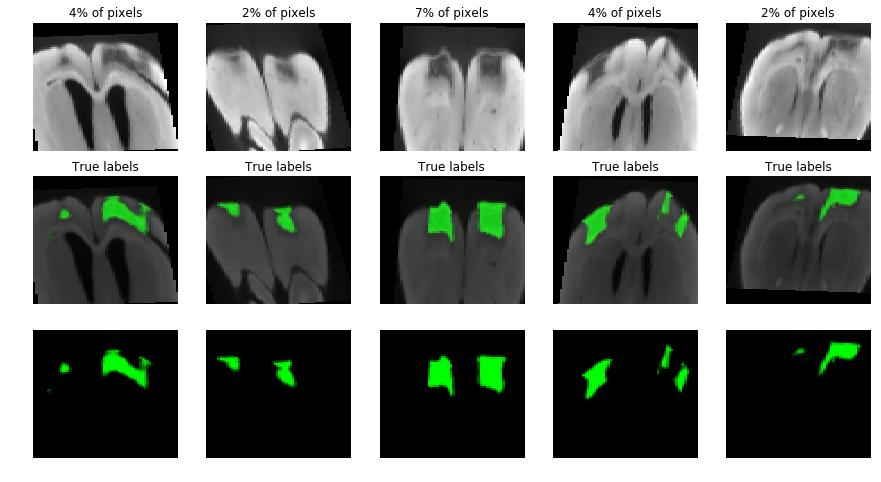

In [9]:
# check dataset
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

plot_masks(data_batch, labels_batch)

In [10]:
one_weight = 0.95 # class weights
zero_weight = 0.05

# consider pixel weights also:
# https://stackoverflow.com/questions/50255438/pixel-wise-loss-weight-for-image-segmentation-in-keras

def weighted_binary_crossentropy(y_true, y_pred):

    # Original binary crossentropy (see losses.py):
    # K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)

    # Calculate the binary crossentropy
    b_ce = K.binary_crossentropy(y_true, y_pred)

    # Apply the weights
    weight_vector = y_true * one_weight + (1. - y_true) * zero_weight
    weighted_b_ce = weight_vector * b_ce

    # Return the mean error
    return K.mean(weighted_b_ce)

In [11]:
# modified from https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277
def unet2d(loss_fn=dice_coef_loss, lr=1e-3, act='relu', init='he_normal', pad='same', dropout=False):
    inputs = Input(img_size + (1,))
        
    c1 = Conv2D(16, (3, 3), activation=act, kernel_initializer=init, padding=pad) (inputs)
    c1 = Dropout(0.1) (c1) if dropout else c1
    c1 = Conv2D(16, (3, 3), activation=act, kernel_initializer=init, padding=pad) (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(32, (3, 3), activation=act, kernel_initializer=init, padding=pad) (p1)
    c2 = Dropout(0.1) (c2) if dropout else c2
    c2 = Conv2D(32, (3, 3), activation=act, kernel_initializer=init, padding=pad) (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation=act, kernel_initializer=init, padding=pad) (p2)
    c3 = Dropout(0.2) (c3) if dropout else c3
    c3 = Conv2D(64, (3, 3), activation=act, kernel_initializer=init, padding=pad) (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation=act, kernel_initializer=init, padding=pad) (p3)
    c4 = Dropout(0.2) (c4) if dropout else c4
    c4 = Conv2D(128, (3, 3), activation=act, kernel_initializer=init, padding=pad) (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation=act, kernel_initializer=init, padding=pad) (p4)    
    c5 = Dropout(0.3) (c5)  if dropout else c5
    c5 = Conv2D(256, (3, 3), activation=act, kernel_initializer=init, padding=pad) (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding=pad) (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation=act, kernel_initializer=init, padding=pad) (u6)
    c6 = Dropout(0.2) (c6) if dropout else c6
    c6 = Conv2D(128, (3, 3), activation=act, kernel_initializer=init, padding=pad) (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding=pad) (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation=act, kernel_initializer=init, padding=pad) (u7)
    c7 = Dropout(0.2) (c7) if dropout else c7
    c7 = Conv2D(64, (3, 3), activation=act, kernel_initializer=init, padding=pad) (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding=pad) (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation=act, kernel_initializer=init, padding=pad) (u8)
    c8 = Dropout(0.1) (c8) if dropout else c8
    c8 = Conv2D(32, (3, 3), activation=act, kernel_initializer=init, padding=pad) (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding=pad) (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation=act, kernel_initializer=init, padding=pad) (u9)
    c9 = Dropout(0.1) (c9) if dropout else c9
    c9 = Conv2D(16, (3, 3), activation=act, kernel_initializer=init, padding=pad) (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=Adam(lr=lr), loss=loss_fn, metrics=[dice_coef])
    model.summary()
    
    return model

In [63]:
K.clear_session()
model = unet2d(loss_fn=weighted_binary_crossentropy)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 64, 1)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 64, 16)  160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 64, 16)  2320        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 64, 32, 16)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [64]:
# checkpoint = ModelCheckpoint(filepath='weights.h5')
checkpoint = ModelCheckpoint(filepath='weights2.h5', monitor='val_loss', save_best_only=True)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=20,
    validation_data=valid_generator,
    validation_steps=100,
    verbose=1,
    callbacks=[checkpoint])


Epoch 1/20
100/100 [==============================] - 52s 523ms/step - loss: 0.0475 - dice_coef: 0.1023 - val_loss: 0.0289 - val_dice_coef: 0.1578
Epoch 2/20
100/100 [==============================] - 49s 495ms/step - loss: 0.0333 - dice_coef: 0.2439 - val_loss: 0.0136 - val_dice_coef: 0.4260
Epoch 3/20
100/100 [==============================] - 36s 364ms/step - loss: 0.0212 - dice_coef: 0.3931 - val_loss: 0.0116 - val_dice_coef: 0.5929
Epoch 4/20
100/100 [==============================] - 51s 507ms/step - loss: 0.0206 - dice_coef: 0.4165 - val_loss: 0.0101 - val_dice_coef: 0.5812
Epoch 5/20
100/100 [==============================] - 64s 637ms/step - loss: 0.0197 - dice_coef: 0.4530 - val_loss: 0.0101 - val_dice_coef: 0.5694
Epoch 6/20
100/100 [==============================] - 40s 398ms/step - loss: 0.0163 - dice_coef: 0.5278 - val_loss: 0.0102 - val_dice_coef: 0.6399
Epoch 7/20
100/100 [==============================] - 49s 492ms/step - loss: 0.0184 - dice_coef: 0.4866 - val_loss: 0.

In [43]:
def plot_performance(history):
    dicec = history.history['dice_coef']
    val_dice = history.history['val_dice_coef']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(dicec))
    plt.figure(figsize=(10, 4))
    plt.subplot(1,2,1)
    plt.plot(epochs, dicec, label='Training dice')
    plt.plot(epochs, val_dice, label='Validation dice')
    plt.xlabel("Num of Epochs")
    plt.ylabel("dice")
    plt.title('Training and validation dice')
    plt.legend()

    plt.subplot(1,2,2)

    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.xlabel("Num of Epochs")
    plt.ylabel("Loss")
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

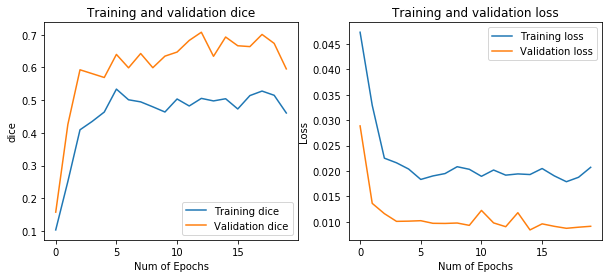

In [65]:
plot_performance(history)

In [ ]:
# load best model
model.load_weights('weights2.h5')

data batch shape: (32, 128, 64, 1)
labels batch shape: (32, 128, 64, 1)


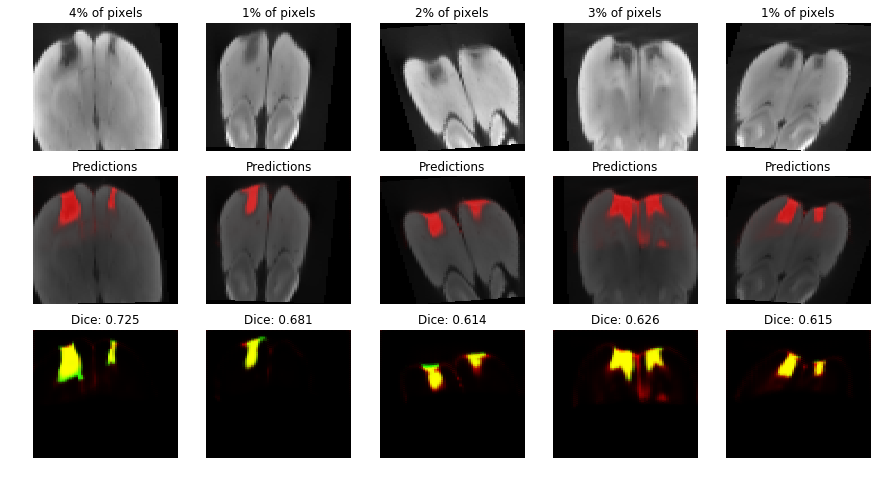

In [25]:
# training set performance
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

predict_batch = model.predict_on_batch(data_batch)
    
plot_masks(data_batch, labels_batch, predict_batch)

data batch shape: (32, 128, 64, 1)
labels batch shape: (32, 128, 64, 1)


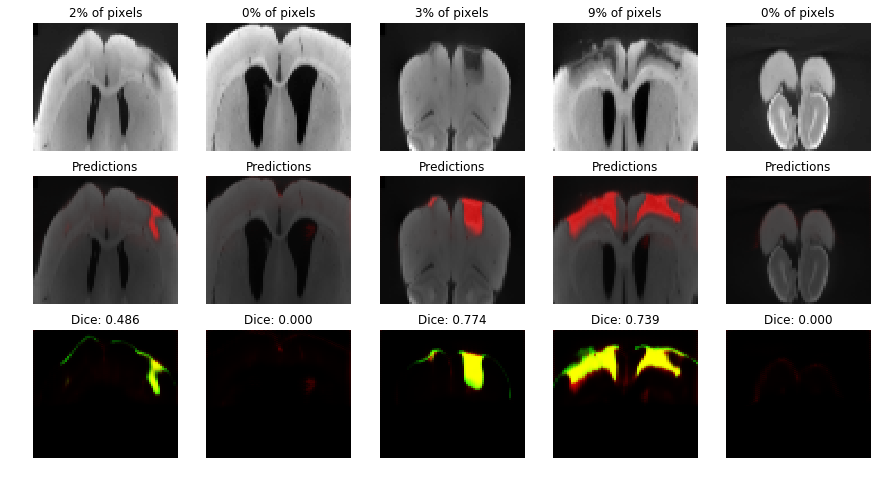

In [18]:
# validation set performance
for data_batch, labels_batch in valid_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

predict_batch = model.predict_on_batch(data_batch)
    
plot_masks(data_batch, labels_batch, predict_batch)


data batch shape: (32, 128, 64, 1)
labels batch shape: (32, 128, 64, 1)


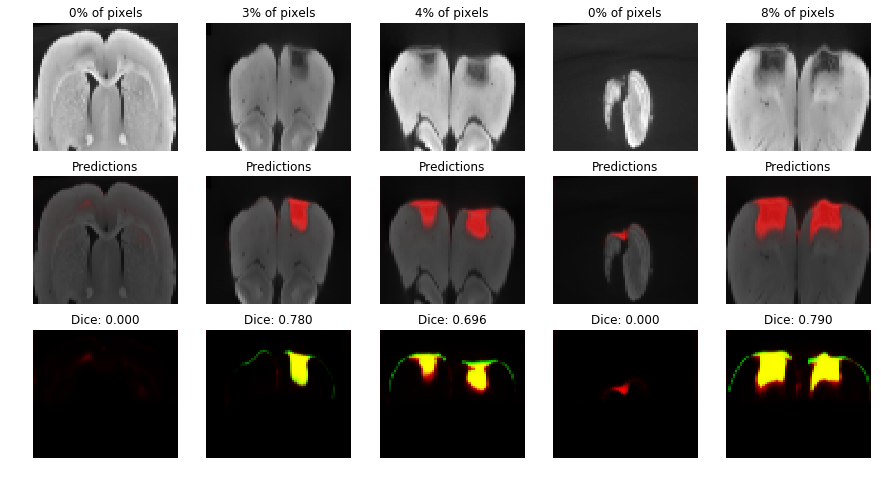

In [31]:
# test set performance
for data_batch, labels_batch in test_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

predict_batch = model.predict_on_batch(data_batch)
    
plot_masks(data_batch, labels_batch, predict_batch)


### 3D U-Net



In [32]:
vol_folder = 'data\\small3d\\'

vols = ['GP1825', 'GP1826', 'GP1827']

for (i, vol) in enumerate(vols):
    train_vol = imread(os.path.join(vol_folder,vol)+'.tif')
    train_vol = train_vol.astype('float') / train_vol.max()
    train_labels = imread(os.path.join(vol_folder,vol)+'_lesion.tif')
    
    factor = train_labels[train_labels>0].min()
    train_labels = np.round(train_labels/factor).astype('uint8')
    
    if i==0:
        X_train = np.moveaxis(np.expand_dims(np.expand_dims(train_vol, axis=3), axis=4), 4, 0)
        y_train = np.moveaxis(np.expand_dims(np.expand_dims(train_labels, axis=3), axis=4), 4, 0)
    else:
        X_train = np.append(X_train, np.moveaxis(np.expand_dims(np.expand_dims(train_vol, axis=3), axis=4), 4, 0), axis=0)
        y_train = np.append(y_train, np.moveaxis(np.expand_dims(np.expand_dims(train_labels, axis=3), axis=4), 4, 0), axis=0)



In [33]:
# since Keras' ImageDataGenerator doesn't support 3D data, we make our own generator here

# https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

class VolumeDataGenerator(Sequence):
    def __init__(self, filenames, root, label_suffix='lesion', batch_size=1, dim=(64, 64, 128), n_channels=1, shuffle=True,
                 rotation_range=10, zoom_range=[0.9, 1.1], brightness_range=[0.8, 1.2], flip_axes=[0, 0, 0], shift_range=5):
        self.dim = dim
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.filenames = filenames
        self.root = root
        if self.batch_size>len(self.filenames):
            self.batch_size=len(self.filenames)
        self.label = label_suffix
        self.shuffle = shuffle
        self.reset_index()
        
        # augmentation parameters
        self.rotation_range = rotation_range
        self.zoom_range = zoom_range
        self.brightness_range = brightness_range
        self.flip_axes = np.roll(flip_axes,-1) # y, z, x --> x, y, z
        self.shift_range = shift_range
    
    def __len__(self): 
        # number of batches per epoch
        return int(np.floor(len(self.filenames) / self.batch_size))
    
    def __getitem__(self, index):
        # Generate one batch of data
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        files = [self.filenames[k] for k in indexes]
        
        X, y = self.load_files(files)
        
        for i, (Xi, yi) in enumerate(zip(X, y)):
            Xi, yi = self.augmentit(np.squeeze(Xi), np.squeeze(yi))
            X[i] = np.expand_dims(Xi, axis=3)
            y[i] = np.expand_dims(yi, axis=3)
        
        return X, y
    
    def reset_index(self):
        # Updates indexes after each epoch
        self.indexes = np.arange(len(self.filenames))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
        
    def load_files(self, files):
        
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim, self.n_channels), dtype=int)
        
        for i, file in enumerate(files):
            img = imread(os.path.join(self.root, file)+'.tif')
            img = img.astype('float') / img.max()
            X[i] = np.expand_dims(img, axis=3)
            
            label = imread(os.path.join(self.root, file)+'_'+self.label+'.tif')
            factor = label[label>0].min()
            label = np.round(label/factor).astype('uint8')
            y[i] = np.expand_dims(label, axis=3)
            
        return X, y
    
    ## the following augmentation functions are copied from 
    # https://mlnotebook.github.io/post/dataaug/
    
    def augmentit(self, thisim, thisseg):
        dims = self.dim
        aug = False        
        
        if self.rotation_range>0:
            theta   = np.random.uniform(-self.rotation_range,self.rotation_range, size=3)
            thisim  = self.rotateit(thisim, theta)
            thisseg = self.rotateit(thisseg, theta, isseg=True) 
            aug = True

        if not np.equal(self.zoom_range, 1).all():
            scalefactor  = float(np.around(np.random.uniform(self.zoom_range[0], self.zoom_range[1], size=1), 2))
            thisim  = self.scaleit(thisim, scalefactor)
            thisseg = self.scaleit(thisseg, scalefactor, isseg=True)
            aug = True

        if not np.equal(self.brightness_range, 1).all():
            factor  = float(np.around(np.random.uniform(self.brightness_range[0], self.brightness_range[1], size=1), 2))
            thisim  = self.intensifyit(thisim, factor)
            aug = True
            #no intensity change on segmentation

        if not np.equal(self.flip_axes, 0).all():
            thisim  = self.flipit(thisim, self.flip_axes)
            thisseg = self.flipit(thisseg, self.flip_axes) 
            aug = True

        if self.shift_range>0:
            offset  = list(np.random.randint(-self.shift_range,self.shift_range, size=3))
            thisim  = self.translateit(thisim, offset)
            thisseg = self.translateit(thisseg, offset, isseg=True)
            aug = True

        if aug:
            thisim, thisseg = self.cropit(thisim, thisseg)
            thisseg         = self.resampleit(thisseg, dims, isseg=True) 
            thisim          = self.resampleit(thisim, dims)

        return thisim, thisseg
    
    def scaleit(self, image, factor, isseg=False):
        order = 0 if isseg == True else 3

        height, width,depth = image.shape
        zheight             = int(np.round(factor * height))
        zwidth              = int(np.round(factor * width))

        if factor < 1.0:
            newimg  = np.zeros_like(image)
            row     = int((height - zheight) / 2)
            col     = int((width - zwidth) / 2)
            newimg[row:row+zheight, col:col+zwidth, :] = interpolation.zoom(image, (float(factor), float(factor),1.0), order=order, mode='nearest')[0:zheight, 0:zwidth, :]

            return newimg

        elif factor > 1.0:
            row     = (zheight - height) // 2
            col     = (zwidth - width) // 2

            newimg = interpolation.zoom(image[row:row+zheight, col:col+zwidth], (float(factor), float(factor),1.0), order=order, mode='nearest')  

            extrah = (newimg.shape[0] - height) // 2
            extraw = (newimg.shape[1] - width) // 2
            newimg = newimg[extrah:extrah+height, extraw:extraw+width, :]

            return newimg

        else:
            return image
        
    def resampleit(self, image, dims, isseg=False):
        order = 0 if isseg == True else 5

        image = interpolation.zoom(image, np.array(dims)/np.array(image.shape, dtype=np.float32), order=order, mode='nearest')

        if isseg:
            image[np.where(image==4)]=3

        return image if isseg else (image-image.min())/(image.max()-image.min()) 
   

    def translateit(self, image, offset, isseg=False, mode='nearest'):
        order   = 0 if isseg else 5
        mode    ='nearest' 
        offset  = (int(offset[0]), int(offset[1]), int(offset[2]))

        return interpolation.shift(image, offset , order=order, mode=mode)


    def rotateit(self, image, theta, isseg=False):
        # modified using https://stackoverflow.com/questions/43922198/how-to-rotate-a-3d-image-by-a-random-angle-in-python
        order = 0 if isseg == True else 5
        for i, angle in enumerate(theta):
            image = interpolation.rotate(image, angle, mode='nearest', axes=(int(i>1), int(i>0)+1), order=order, reshape=False)
        
        return image


    def flipit(self, image, axes):

        if axes[0]:
            image = np.fliplr(image)
        if axes[1]:
            image = np.flipud(image)
        if axes[2]:
            image = np.flip(image, axis=2)

        return image


    def intensifyit(self, image, factor):

        return image*float(factor)


    def cropit(self, image, seg=None, margin=5):

        shortaxis = np.argmin(image.shape[:2])
        trimaxes  = 0 if shortaxis == 1 else 1

        trim    = image.shape[shortaxis]
        center  = image.shape[trimaxes] // 2   
        lrcenter = image.shape[shortaxis] // 2

        if seg is not None:

            hits = np.where(seg!=0)
            mins = np.amin(hits, axis=1)
            maxs = np.amax(hits, axis=1)
            segtrim = max(maxs-mins) + margin

            trim = segtrim
            center  = np.mean(hits, 1, dtype=int)[0] 
            lrcenter = np.mean(hits, 1, dtype=int)[1] 

            if center - (trim // 2) > mins[0]:
                while center - (trim // 2) > mins[0]:
                    center = center - 1
                center = center

            if center + (trim // 2) < maxs[0]:
                while center + (trim // 2) < maxs[0]:
                    center = center + 1
                center = center

            if lrcenter - (trim // 2) > mins[1]:
                while lrcenter - (trim // 2) > mins[1]:
                    lrcenter = lrcenter - 1
                lrcenter = lrcenter

            if lrcenter + (trim // 2) < maxs[1]:
                while lrcenter + (trim // 2) < maxs[1]:
                    lrcenter = lrcenter + 1
                lrcenter = lrcenter

        top    = max(0, center - (trim //2) - margin//2)
        bottom = trim + margin if top == 0 else top + trim + (margin//2)
        left = max(0, lrcenter - (trim//2) - margin//2)
        right = trim + margin if left == 0 else left + trim + (margin//2)

        # image[center-5:center+5, lrcenter-5:lrcenter+5, :] = 255
        # image[top:bottom, left-2:left+2, :] = 255
        # image[top:bottom, right-2:right+2, :] = 255
        # image[top-2:top+2, left:right, :] = 255
        # image[bottom-2:bottom+2, left:right, :] = 255

        if bottom > image.shape[trimaxes]:
            bottom = image.shape[trimaxes]
            top = bottom - trim

        if right > image.shape[shortaxis]:
            right = image.shape[shortaxis]
            left = right - trim

        image   = image[top: bottom, left:right]

        if seg is not None:
            seg   = seg[top: bottom, left:right]

            return image, seg
        else:
            return image
    
    

C:\Users\Gerald\Anaconda3\envs\tf3\lib\site-packages\scipy\ndimage\interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


1.9856905937194824


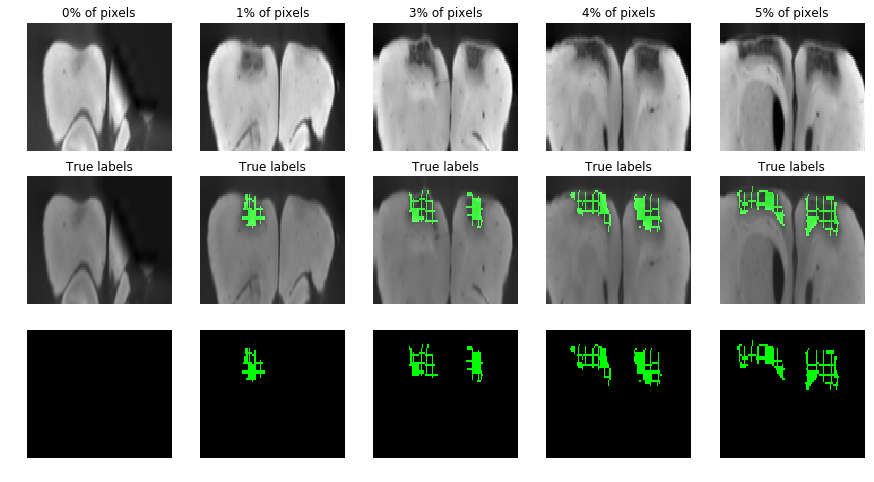

In [34]:
filenames = ['GP1825', 'GP1826', 'GP1827']
root = 'data\\small3d\\'

vol_size = (64, 64, 128)
train_gen = VolumeDataGenerator(filenames, root, rotation_range=10, zoom_range=[0.8, 1.2], brightness_range=[0.8, 1.2], 
                                flip_axes=[1,0,1], shift_range=5)

noaug_gen = VolumeDataGenerator(filenames, root, rotation_range=0, zoom_range=[1, 1], brightness_range=[1, 1], 
                                flip_axes=[0,0,0], shift_range=0, shuffle=False, batch_size=3)

start = time.time()
X, y = train_gen.__getitem__(0)
print(time.time()-start)

# preview the augmentation
plot_masks(X[0][4:-1:8], y[0][4:-1:8]>1)

The masks look like checkboards because I only sparsely annotated the volumes in each orthogonal dimension -- they are not perfect checkboards because of the random rotation.

In [36]:
n_classes = y.max()+1
class_weights = np.array([0, 0.05, 0.95])

def weighted_categorical_crossentropy(y_true, y_pred):

    # categorical cross entropy
    y_true_fixed = K.relu(y_true-1) # shift category labels
    c_ce = K.sparse_categorical_crossentropy(y_true_fixed, y_pred)
    
    # Apply class weights
    weight_vector = K.squeeze(K.sum(K.one_hot(K.cast(y_true, 'int32'), n_classes) * class_weights, axis=-1), axis=-1)
#     weight_vector = y_true * one_weight + (1. - y_true) * zero_weight    
    weighted_c_ce = weight_vector * c_ce
#     weighted_c_ce = c_ce
#     weighted_c_ce = c_ce*class_weights
    
    # Return the mean error
    return K.mean(weighted_c_ce)


In [37]:
# modified from https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277
def unet3d(loss_fn=weighted_categorical_crossentropy, lr=1e-3, act='relu', init='he_normal', pad='same', dropout=False):
    inputs = Input(vol_size + (1,))
        
    c1 = Conv3D(16, (3, 3, 3), activation=act, kernel_initializer=init, padding=pad) (inputs)
    c1 = Dropout(0.1) (c1) if dropout else c1
    c1 = Conv3D(16, (3, 3, 3), activation=act, kernel_initializer=init, padding=pad) (c1)
    p1 = MaxPooling3D((2, 2, 2)) (c1)

    c2 = Conv3D(32, (3, 3, 3), activation=act, kernel_initializer=init, padding=pad) (p1)
    c2 = Dropout(0.1) (c2) if dropout else c2
    c2 = Conv3D(32, (3, 3, 3), activation=act, kernel_initializer=init, padding=pad) (c2)
    p2 = MaxPooling3D((2, 2, 2)) (c2)

    c3 = Conv3D(64, (3, 3, 3), activation=act, kernel_initializer=init, padding=pad) (p2)
    c3 = Dropout(0.2) (c3) if dropout else c3
    c3 = Conv3D(64, (3, 3, 3), activation=act, kernel_initializer=init, padding=pad) (c3)
    p3 = MaxPooling3D((2, 2, 2)) (c3)

    c4 = Conv3D(128, (3, 3, 3), activation=act, kernel_initializer=init, padding=pad) (p3)
    c4 = Dropout(0.2) (c4) if dropout else c4
    c4 = Conv3D(128, (3, 3, 3), activation=act, kernel_initializer=init, padding=pad) (c4)    
    
    # remove one layer of depth to save on model size / memory
    p4 = MaxPooling3D(pool_size=(2, 2, 2)) (c4)
    
    c5 = Conv3D(256, (3, 3, 3), activation=act, kernel_initializer=init, padding=pad) (p4)    
    c5 = Dropout(0.3) (c5)  if dropout else c5
    c5 = Conv3D(256, (3, 3, 3), activation=act, kernel_initializer=init, padding=pad) (c5)

    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding=pad) (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation=act, kernel_initializer=init, padding=pad) (u6)
    c6 = Dropout(0.2) (c6) if dropout else c6
    c6 = Conv3D(128, (3, 3, 3), activation=act, kernel_initializer=init, padding=pad) (c6)
    # end remove

    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding=pad) (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation=act, kernel_initializer=init, padding=pad) (u7)
    c7 = Dropout(0.2) (c7) if dropout else c7
    c7 = Conv3D(64, (3, 3, 3), activation=act, kernel_initializer=init, padding=pad) (c7)

    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding=pad) (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation=act, kernel_initializer=init, padding=pad) (u8)
    c8 = Dropout(0.1) (c8) if dropout else c8
    c8 = Conv3D(32, (3, 3, 3), activation=act, kernel_initializer=init, padding=pad) (c8)

    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding=pad) (c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation=act, kernel_initializer=init, padding=pad) (u9)
    c9 = Dropout(0.1) (c9) if dropout else c9
    c9 = Conv3D(16, (3, 3, 3), activation=act, kernel_initializer=init, padding=pad) (c9)

    outputs = Conv3D(n_classes-1, (1, 1, 1), activation='softmax') (c9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=Adam(lr=lr), loss=loss_fn, metrics=[loss_fn])
    model.summary()
    
    return model

In [38]:
K.clear_session()
model = unet3d(loss_fn=weighted_categorical_crossentropy, dropout=False)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 128,  0                                            
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 64, 64, 128,  448         input_1[0][0]                    
__________________________________________________________________________________________________
conv3d_2 (Conv3D)               (None, 64, 64, 128,  6928        conv3d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling3d_1 (MaxPooling3D)  (None, 32, 32, 64, 1 0           conv3d_2[0][0]                   
__________________________________________________________________________________________________
conv3d_3 (

In [39]:
# history = model.fit(x=X_train, y=y_train, batch_size=2, epochs=50, verbose=1)
# history = model.fit_generator(noaug_gen, steps_per_epoch=3, epochs=20, verbose=1)
checkpoint = ModelCheckpoint(filepath='weights3.h5')

history = model.fit_generator(train_gen, steps_per_epoch=30, epochs=20, verbose=1, callbacks=[checkpoint])


Epoch 1/20
 2/30 [=>............................] - ETA: 1:16 - loss: 0.0189 - weighted_categorical_crossentropy: 0.0189

C:\Users\Gerald\Anaconda3\envs\tf3\lib\site-packages\scipy\ndimage\interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


30/30 [==============================] - 58s 2s/step - loss: 0.0211 - weighted_categorical_crossentropy: 0.0211
Epoch 2/20
30/30 [==============================] - 54s 2s/step - loss: 0.0208 - weighted_categorical_crossentropy: 0.0208
Epoch 3/20
30/30 [==============================] - 55s 2s/step - loss: 0.0190 - weighted_categorical_crossentropy: 0.0190
Epoch 4/20
30/30 [==============================] - 56s 2s/step - loss: 0.0129 - weighted_categorical_crossentropy: 0.0129
Epoch 5/20
30/30 [==============================] - 57s 2s/step - loss: 0.0209 - weighted_categorical_crossentropy: 0.0209
Epoch 6/20
30/30 [==============================] - 56s 2s/step - loss: 0.0132 - weighted_categorical_crossentropy: 0.0132
Epoch 7/20
30/30 [==============================] - 55s 2s/step - loss: 0.0075 - weighted_categorical_crossentropy: 0.0075
Epoch 8/20
30/30 [==============================] - 55s 2s/step - loss: 0.0056 - weighted_categorical_crossentropy: 0.0056
Epoch 9/20
30/30 [=========

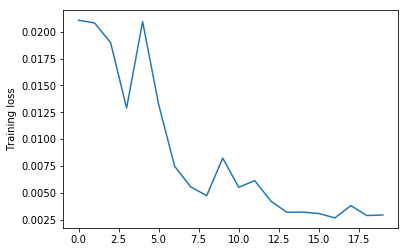

In [46]:
plt.plot(history.history['loss'])
plt.ylabel('Training loss')

13.136070251464844
GP1825
GP1826
GP1827


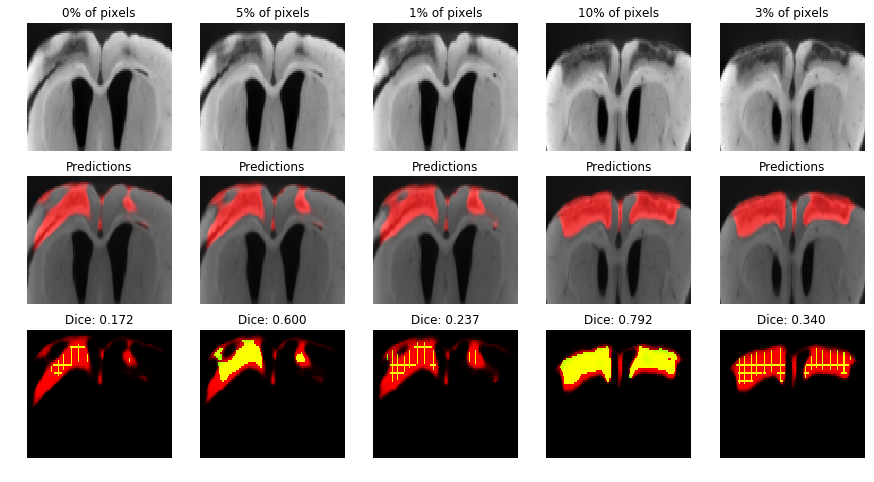

In [62]:
# make predictions on non-augmented data
noaug_gen.reset_index()
y_predict = model.predict_generator(noaug_gen)

# plot predictions
noaug_gen.reset_index()
X, y_true = noaug_gen.__getitem__(0)
y_pred=np.expand_dims(y_predict[:,:,:,:,1],axis=4)
# plot the predictions
idx = [18, 19, 20, 27, 28]
plot_masks(X[2][idx], (y_true[2][idx]>1).astype('float'), y_pred[2][idx])

# save class labels
y_argmax = np.argmax(y_predict, axis=4).astype('float')
y_argmax *= 255/y_argmax.max()
y_argmax = np.round(y_argmax).astype('uint8')

# prediction probability
y_predict = y_predict[:,:,:,:,1]*255
y_predict = y_predict.astype('uint8')
print(y_predict.mean())

# save prediction volumes to disk
for (i, vol) in enumerate(vols):
    print(vol)
    outfile = os.path.join(vol_folder,vol) + '_prob.tif'
    imsave(outfile, y_predict[i])
    
    outfile = os.path.join(vol_folder,vol) + '_pred.tif'
    imsave(outfile, y_argmax[i])

    